Cells below were created as notes while watching Andrej Karpathy's video "[Let's build GPT: from scratch, in code, spelled out.
](https://www.youtube.com/watch?v=kCc8FmEb1nY)". Check it out if you haven't!


In [329]:
%%capture 
%pip install torch transformers numpy matplotlib networkx

In [327]:
import torch

torch.manual_seed(1337)
device = "cuda" if torch.cuda.is_available() else "cpu"


### Tokens - encoding text to a numeric format

Tokens are numerical representations of the smallest meaningful units of text in natural language. They can represent words, subwords, characters or even symbols.


As an example, let's look at the tokens used in GPT-2:


In [168]:
from transformers import GPT2Tokenizer

# This is the tokenizer used by GPT-2.
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

test_str = "A string to demonstrate the tokenizer."

# GPT-2 used a subword tokenizer, meaning that each token corresponds to part of a word
str_enc = tokenizer.encode(test_str)  # Tokenized string
print([tokenizer.decode([s]) for s in str_enc])
print(str_enc)


['A', ' string', ' to', ' demonstrate', ' the', ' token', 'izer', '.']
[32, 4731, 284, 10176, 262, 11241, 7509, 13]


As can be seen, the text was split into pieces corresponding to a combination of words, subwords and special characters and converted into tokens in the form of integers.


The set of available tokens is called the _vocabulary_.


In [169]:
from random import sample

# Let's decode a few tokens back to text and print them...
tokens = tokenizer.get_vocab().keys()
print([tokenizer.convert_tokens_to_string([t]) for t in sample(tokens, 20)])

print(f"Vocab size: {tokenizer.vocab_size}")


[' sun', 'sts', ' Norfolk', 'bare', 'arted', 'ttp', ' Related', ' years', ' Tub', ' Se', 'lio', 'awei', 'jong', 'マ', ' blender', ' emerging', ' graphic', 'oned', ' proponent', ' Strange']
Vocab size: 50257


In [170]:
# For this tokenizer, tokens correspond to subwords. Because of this, the encoded sequence is longer than the amount of words in the text.
print(f"Length of text: {len(test_str.split(' '))}")
print(f"Length of encoded seq: {len(str_enc)}")


Length of text: 6
Length of encoded seq: 8


For this example, we will be using text from Shakespeare as our corpus.


In [171]:
import os
import base64
import requests

if not os.path.exists("input.txt"):
    url = "https://raw.githubusercontent.com/jbergq/nlp-refresher/main/input.txt"
    req = requests.get(url)

    with open("input.txt", "w") as f:
        f.write(
            req.text,
        )

# Load data
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(text[:300])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


We will be using a very simple tokenization scheme - encoding single characters as tokens.

Therefore, our vocabulary will consist of all symbols used in the text.


In [172]:
vocab = sorted(list(set(text)))
print("".join(vocab))

vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocab size: 65


Note that our vocabulary is much smaller compared to the GPT-2 tokenizer. Keep this in mind as we continue!


In [173]:
# Simple tokenization scheme by using the character's index in the vocabulary as its token.
stoi = {ch: i for i, ch in enumerate(vocab)}  # string-to-integer
itos = {i: ch for i, ch in enumerate(vocab)}  # integer-to-string

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])


Let's encode our original example text again, now using this simple tokenizer


In [174]:
print(encode(test_str))
print(decode(encode(test_str)))


[13, 1, 57, 58, 56, 47, 52, 45, 1, 58, 53, 1, 42, 43, 51, 53, 52, 57, 58, 56, 39, 58, 43, 1, 58, 46, 43, 1, 58, 53, 49, 43, 52, 47, 64, 43, 56, 8]
A string to demonstrate the tokenizer.


Let's check how our encoded sequence compares to the original text in length now.


In [175]:
print(f"Length of text: {len(test_str.split(' '))}")
print(f"Length of encoded seq: {len(encode(test_str))}")


Length of text: 6
Length of encoded seq: 38


See how it is much longer? Since we are using a smaller vocabulary, we must use more tokens to encode our sequences.

This shows the inherent relationship between vocabulary size and sequence length - a smaller vocabulary results in longer sequences.


In [176]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data[:100])


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [177]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


In [178]:
block_size = 16
train_data[: block_size + 1]


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43])

### Bigram model

Let's build arguably the simplest language model possible - a bigram model, which predicts the next token based on the previous token only. This means that we are modeling our text as Markov process, where the probability of the next state (token) only depends on the present state (the previous token),


In [179]:
def get_batch(split, block_size, batch_size):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


In [180]:
import torch.nn as nn
import torch.nn.functional as F


class LanguageModel(nn.Module):
    def __init__(self, block_size) -> None:
        super().__init__()

        self.block_size = block_size

    def generate(self, idx, num_steps):
        for _ in range(num_steps):
            out = self.forward(idx[..., -block_size:])
            logits = out[0][:, -1, :]

            # Note: Sampling is probabilistic.
            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [181]:
class BigramLanguageModel(LanguageModel):
    def __init__(self, vocab_size) -> None:
        super().__init__(block_size=1)

        self.embedding = torch.nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        logits = self.embedding(idx)

        if targets is not None:
            B, T, C = logits.shape
            logits_ = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits_, targets)
        else:
            loss = None

        return logits, loss


model = BigramLanguageModel(vocab_size)
model = model.to(device)


In [182]:
batch_size = 4
block_size = 8

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

for iter in range(10000):
    xb, yb = get_batch("train", block_size, batch_size)

    logits, loss = model(xb, yb)

    loss.backward()
    optimizer.step()

    if iter % 1000 == 0:
        print(f"Train loss: {loss}")


Train loss: 4.671344757080078
Train loss: 2.8598055839538574
Train loss: 2.6134743690490723
Train loss: 2.100557804107666
Train loss: 2.424243211746216
Train loss: 2.729647159576416
Train loss: 2.6514675617218018
Train loss: 2.267066478729248
Train loss: 2.7564337253570557
Train loss: 2.6486752033233643


In [183]:
output = model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), 1000)

print(decode(output[0].tolist()))




tou o d Whangt IUS: buthourin: bad myoll d t
W:
ALour alere o foullor, fof s, buler n gantherwo t'l tasthichered ge 'll teowe de,

NCENGO:


RAnge sar f h'sl's, t thare:
OLAnde s
LLLes, y thaltwhrthe'teanontooker, thayotimeanseme me.
Whan fain mon ad IO s s le INETomigh goufoupreamad, swest:
He, theffual I leaingyon ILESelll, a toorir ge idasadil, batise ir I t at, l s besthe tranot w tito,
Whe hattoft d s,
Henghinis be, u riseno wacotheyoncir my til, m es. s t
Thod yo atr herd mofelave
ISeroo aif bar tsottist llenematifos inofo? Gonge.
QULAN:
F theatorespp d thartous ve w
mbler, fousthente han.
Hindilinongor w:
IUS:
INComan D ter somare w t, mepitomy
My beak'doferaver be beie h and;
I'dendoie thy.
Fru anongol or byothy, n O: u ald fred, INGe h ve thath won:

Tore my tenecten pindowed s tr ayond in y ds,
O:
Th tis t:
Kin vepee INGonsin giveiliry g iowrs t shollome reedok berry lle, ie w sme ly ly' be d y mithatrthetat ond t shetoveay gofe.
ULIONETomandour tore areend g: wond aret an 

Not that bad, but far from perfect.


Naive way to predict next token is by using the mean of all previous token's embeddings.

$$ \hat{x*t} = f(\Sigma*{i=0}^{t-1} x_i) $$


In [326]:
T, C = 6, 4

# Let's create a mock sequence of embedded tokens. Let's give each row incrementing values to more easily see what happens.
x = torch.arange(1, T + 1).view(-1, 1).repeat(1, C).float()

print(x.shape)
print(x)


torch.Size([6, 4])
tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.],
        [4., 4., 4., 4.],
        [5., 5., 5., 5.],
        [6., 6., 6., 6.]])


In [185]:
# Slow way, for-loop...


def mean(x):
    xbow = torch.zeros((T, C))

    for t in range(T):  # For each time step in seq.
        xprev = x[: t + 1, :]
        xbow[t] = torch.mean(xprev, dim=0)

    return xbow


print(mean(x))


tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [2.0000, 2.0000, 2.0000, 2.0000],
        [2.5000, 2.5000, 2.5000, 2.5000],
        [3.0000, 3.0000, 3.0000, 3.0000],
        [3.5000, 3.5000, 3.5000, 3.5000]])


In [186]:
# Fast way - matrix mult!

wei = torch.tril(torch.ones(T, T))  # Create lower triangular matrix.
print(wei)


tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [187]:
# When matmuled with sequence with shape (T, C), we almost get what we want - we get the sum of the rows, but not the mean.
print(wei @ x)


tensor([[ 1.,  1.,  1.,  1.],
        [ 3.,  3.,  3.,  3.],
        [ 6.,  6.,  6.,  6.],
        [10., 10., 10., 10.],
        [15., 15., 15., 15.],
        [21., 21., 21., 21.]])


In [188]:
# To get the mean instead, we normalize each row to sum to 1.
row_norm = wei.sum(dim=1, keepdim=True)
wei = wei / row_norm

print(wei @ x)


tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [2.0000, 2.0000, 2.0000, 2.0000],
        [2.5000, 2.5000, 2.5000, 2.5000],
        [3.0000, 3.0000, 3.0000, 3.0000],
        [3.5000, 3.5000, 3.5000, 3.5000]])


Let's compare speeds


In [189]:
%%timeit
wei @ x 

2.18 µs ± 19.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [190]:
%%timeit
mean(x)


86.8 µs ± 5.17 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


More than 10x faster, and we are not even using the GPU - not bad


Now, there is one more way to achieve the same outcome using softmax across each row, which normalizes it to sum to 1. To mask out future tokens, we replace their values by -inf first.


In [191]:
tri = torch.tril(torch.ones(T, T))

wei = torch.ones((T, T))
wei = wei.masked_fill(tri == 0, -torch.inf)
wei = F.softmax(wei, dim=1)

print(wei)
print(wei @ x)


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])
tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [2.0000, 2.0000, 2.0000, 2.0000],
        [2.5000, 2.5000, 2.5000, 2.5000],
        [3.0000, 3.0000, 3.0000, 3.0000],
        [3.5000, 3.5000, 3.5000, 3.5000]])


The reason this is interesting is because this approach works regardless of the initial values of the weights matrix.

We can fill it with random values and still get rows that are normalized to 1:


In [192]:
wei = torch.randn((T, T))
wei = wei.masked_fill(tri == 0, -torch.inf)
wei = F.softmax(wei, dim=1)

wei


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7089, 0.2911, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5166, 0.3210, 0.1624, 0.0000, 0.0000, 0.0000],
        [0.1616, 0.3187, 0.1423, 0.3774, 0.0000, 0.0000],
        [0.3024, 0.1149, 0.0874, 0.4666, 0.0287, 0.0000],
        [0.1292, 0.1173, 0.1132, 0.0494, 0.1582, 0.4326]])

TODO: Describe how this can be intepreted as affinities, or coupling, between tokens.


## Self-attention


Now, can we do better than a simple average of the previous tokens? Indeed we can! We can do a weighted sum, where the weights represent the importance of each token. Even better, we can do a _learned_ weighted sum, where the weights are data-dependent.

This is in fact exactly what the mechanism underlying transformers does, so called _self-attention_. It works like this:

1. Each token emits three values: 1) a query _Q_, telling other tokens what it is "looking for", 2) a key _K_, telling other tokens its own identity, and 3) a value _V_, representing the token in the weighted sum. These are all outputs of learned functions, typically `nn.Linear` layers.
2. Every token's query is multiplied through a dot-product with every other token's key, giving the _attention weights_ $\alpha$.
3. The attention weights are used to do a weighted sum of the values to produce the output features.

The image below shows a single token's query interacting with the keys and values of the other tokens:

![Alt text](./images/attention_example.svg)

Remember that for a generative language model like GPT, we only want a given token $x_t$ to interact with the tokens that came before, hence $\alpha_{i>t} = 0$.


Like mentioned above, the queries, keys and values are outputs of `nn.Linear` layers.


In [193]:
head_size = 32

x = torch.randn(T, C)

key = nn.Linear(C, head_size)
query = nn.Linear(C, head_size)
value = nn.Linear(C, head_size)

k = key(x)  # (T, head_size)
q = query(x)  # (T, head_size)
v = value(x)  # (T, head_size)

wei = q @ k.T  # (T, head_size) @ (head_size, T) = (T, T)
wei = wei.masked_fill(tri == 0, -torch.inf)
wei = F.softmax(wei, dim=1)

print(wei)
print(wei @ v)


tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.9165e-01, 4.0835e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.1789e-01, 6.5987e-02, 6.1612e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.5868e-06, 1.2830e-02, 9.8440e-01, 2.7620e-03, 0.0000e+00, 0.0000e+00],
        [9.9107e-01, 2.0629e-03, 4.1371e-04, 3.6758e-04, 6.0813e-03, 0.0000e+00],
        [9.7590e-01, 6.9176e-03, 1.0155e-03, 5.5064e-03, 2.5252e-03, 8.1350e-03]],
       grad_fn=<SoftmaxBackward0>)
tensor([[-0.7291,  2.2285,  2.4719,  1.1753,  1.3283, -2.6645,  0.1657, -1.7303,
         -1.5886, -1.9180,  0.2320, -1.8639,  0.8100,  2.0086,  1.2171,  0.0767,
          1.2085, -1.0426, -2.1063, -0.2117,  0.6198, -2.5657, -3.2720, -2.2933,
         -0.4154,  1.4644,  1.3094, -0.0176, -0.9738, -0.8888, -0.6673,  1.0015],
        [-0.2837,  1.2334,  1.3860,  0.5857,  0.4858, -1.5227,  0.0211, -1.1075,
         -0.8909, -1.2555,  0.1499, -1.0270,  0.5117,  1.2732,  0.

In the original transformer paper used a particular implementation of self-attention called _scaled dot-product attention_.

$$
Attention(Q, K, V) = softmax\biggl(\frac{Q K^T}{\sqrt{d}}V\biggr)
$$

<img src="./images/scaled_dot_product_attn.svg" width="256" style="margin:auto"/>


There is one piece still missing - the scaling by $1/\sqrt{d_K}$. This is done in order to ensure a that `wei` has unit variance.


In [194]:
k = torch.randn(T, head_size)
q = torch.randn(T, head_size)
wei = q @ k.T
wei_norm = wei * 1 / head_size**0.5

print(k.var())
print(q.var())
print(wei.var())
print(wei_norm.var())


tensor(1.0999)
tensor(0.9475)
tensor(28.0048)
tensor(0.8751)


Without this normalization, `wei` might not be sufficiently uniform and result in a spiky distribution when fed into the softmax function. This would cause tokens to almost only interact with single other tokens, slowing down learning.


In [195]:
attn = F.softmax(wei.masked_fill(tri == 0, -torch.inf), dim=1)
attn_norm = F.softmax(wei_norm.masked_fill(tri == 0, -torch.inf), dim=1)


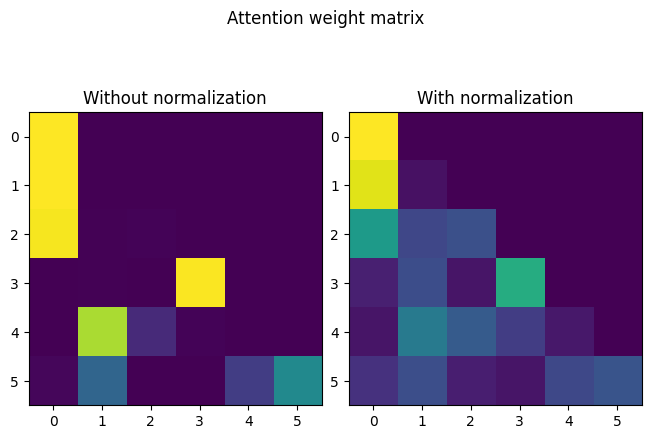

In [196]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, layout="constrained")
axs[0].imshow(attn)
axs[1].imshow(attn_norm)
axs[0].title.set_text("Without normalization")
axs[1].title.set_text("With normalization")
fig.suptitle("Attention weight matrix")
plt.show()


In [315]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, emb_size, head_size, block_size, dropout_p=0.2) -> None:
        super().__init__()

        self.head_size = head_size

        self.query = nn.Linear(emb_size, head_size, bias=False)
        self.key = nn.Linear(emb_size, head_size, bias=False)
        self.value = nn.Linear(emb_size, head_size, bias=False)

        self.register_buffer("tri", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x)  # (B, T, head_size)
        k = self.key(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        wei = q @ k.transpose(-2, -1)  # (B, T, head_size) @ (B, head_size, T) = (B, T, T)
        wei = wei * self.head_size**-0.5  # <-- "Scaled"
        wei = wei.masked_fill(self.tri[:T, :T] == 0, -torch.inf)
        wei = F.softmax(wei, dim=-1)

        out = self.dropout(wei) @ v  # (B, T, T) @ (B, T, head_size) = (B, T, head_size)

        return out, wei


Self-attention is typically combined with other layers to form a transformer block. There are a few more concepts we need before we are ready to do this. These are:

1. Skip connections
2. Layer normalization
3. Dropout


### Skip connections


In [316]:
# TODO describe:
# 1. "Highway" - Allows gradients to "flow". Crucial for deep networks
# 2. "Slowly come online" - Allows weight block to "kick in" over time during training


### Layer normalization


<img src="./images/layer_norm.png" height="512" style="margin:auto"/>


In [317]:
# TODO describe layer norm and why it is preferred


Let's put everything together and build our transformer block. Here it is:


In [318]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_size, head_size, num_heads=4, block_size=32, expansion=4, dropout_p=0.2) -> None:
        super().__init__()

        self.heads = nn.ModuleList(
            ScaledDotProductAttention(emb_size, head_size, block_size, dropout_p) for _ in range(num_heads)
        )
        self.proj = nn.Linear(head_size * num_heads, emb_size)
        self.dropout = nn.Dropout(dropout_p)

        # fmt: off
        self.ff = nn.Sequential(
            *[
                nn.Linear(emb_size, emb_size * expansion),
                nn.ReLU(),
                nn.Linear(emb_size * expansion, emb_size),
                nn.Dropout(dropout_p),
            ]
        )
        # fmt: on

        self.l1 = nn.LayerNorm(emb_size)
        self.l2 = nn.LayerNorm(emb_size)

    def forward_heads(self, x):
        head_outs, attns = tuple(map(list, zip(*[head(x) for head in self.heads])))
        heads_cat = torch.cat(head_outs, dim=-1)

        x = self.proj(heads_cat)
        x = self.dropout(x)

        return x, attns

    def forward(self, x):
        heads_out, attns = self.forward_heads(self.l1(x))
        x = x + heads_out
        x = x + self.ff(self.l2(x))

        return x, attns


Multiple transformer blocks can be stacked on top of each other to form a deeper network:


In [319]:
B, T, C = 1, 4, 2
x0 = torch.randn(B, T, C)

num_blocks = 4
blocks = [TransformerBlock(C, head_size=32, num_heads=4, block_size=32) for _ in range(num_blocks)]

xs = [x0]
attns = []
for block in blocks:
    x, attn = block(xs[-1])
    xs.append(x)
    attns.append(attn)

print("\n".join([str(x) for x in xs]))


tensor([[[ 0.2487, -0.1771],
         [-0.8189,  0.5091],
         [ 1.5341, -1.4629],
         [-0.7150,  0.2237]]])
tensor([[[-0.2515, -0.6576],
         [-0.8189, -0.0823],
         [ 1.1228, -2.0028],
         [-1.0591,  0.2237]]], grad_fn=<AddBackward0>)
tensor([[[-0.2341, -0.4681],
         [-0.9354,  0.4788],
         [ 1.1179, -1.9584],
         [-0.8676,  0.8907]]], grad_fn=<AddBackward0>)
tensor([[[-0.1518,  0.1083],
         [ 0.0386,  1.2293],
         [ 1.1919, -1.9584],
         [ 0.1060,  1.4672]]], grad_fn=<AddBackward0>)
tensor([[[-0.3513,  0.2388],
         [ 0.0386,  1.1119],
         [ 1.6441, -2.1042],
         [-0.5943,  1.5457]]], grad_fn=<AddBackward0>)


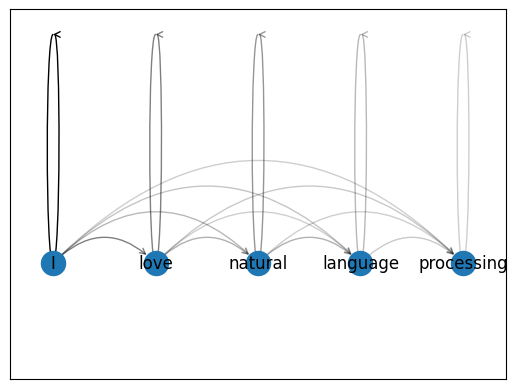

In [320]:
import networkx as nx


def visualize_attention_weights(labels, attention_weights):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (tokens) to the graph
    for i, token in enumerate(labels):
        G.add_node(i)

    # Add weighted edges to the graph
    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            weight = attention_weights[i][j]
            G.add_edge(i, j, weight=weight)

    # Compute positions for the nodes with reversed order
    pos = {i: (len(labels) - 1 + i, 0) for i, token in enumerate(labels)}

    # Draw the graph
    nx.draw_networkx_nodes(G, pos)

    # Draw the edges with opacity based on attention weights
    for edge in G.edges(data=True):
        weight = edge[2]["weight"]
        nx.draw_networkx_edges(
            G, pos, edgelist=[(edge[0], edge[1])], connectionstyle="arc3,rad=0.5", alpha=weight, arrowstyle="<-"
        )

    # selfloop_edges = [(e, e) for e in nx.nodes_with_selfloops(G)]
    # nx.draw_networkx_edges(G, pos, edgelist=selfloop_edges)

    # Draw text labels for nodes
    nx.draw_networkx_labels(G, pos, labels, font_size=12, font_family="sans-serif")


tokens = ["I", "love", "natural", "language", "processing"]
attention_weights = [
    [0.2, 0.5, 0.1, 0.3, 0.1],
    [0.5, 0.5, 0.2, 0.1, 0.2],
    [0.1, 0.2, 0.5, 0.6, 0.1],
    [0.3, 0.1, 0.6, 0.5, 0.3],
    [0.1, 0.2, 0.1, 0.2, 0.1],
]
attention_weights = torch.tensor(attention_weights)
T = attention_weights.shape[0]
tri = torch.tril(torch.ones(T, T))
attention_weights = attention_weights.masked_fill(tri == 0, -torch.inf)
attention_weights = F.softmax(attention_weights, dim=1)

visualize_attention_weights({i: label for i, label in enumerate(tokens)}, attention_weights.tolist())


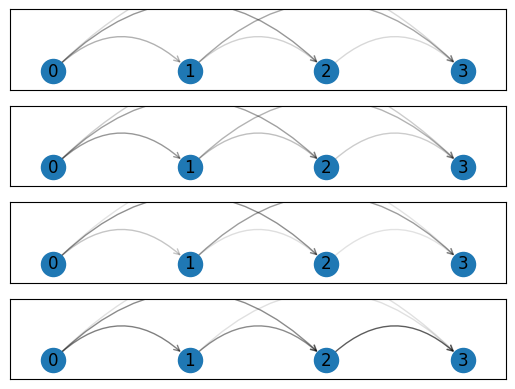

In [321]:
fig, ax = plt.subplots(num_blocks, 1, num=1)

for i, (x, attn) in enumerate(zip(xs, attns)):
    B, T, C = x.shape
    ix = np.unravel_index(i, ax.shape)
    plt.sca(ax[ix])
    visualize_attention_weights({i: i for i in range(T)}, attn[0].tolist()[0])

plt.show()


## Transformer implementation


Let's build a simple transformer!


In [322]:
class Transformer(LanguageModel):
    def __init__(self, emb_size, vocab_size, head_size, num_heads, block_size, num_blocks, expansion, dropout_p=0.2) -> None:
        super().__init__(block_size=block_size)

        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pos_emb = nn.Embedding(block_size, emb_size)

        self.blocks = [
            TransformerBlock(emb_size, head_size, num_heads, block_size, expansion, dropout_p) for _ in range(num_blocks)
        ]

        self.ln_out = nn.LayerNorm(emb_size)
        self.out_head = nn.Linear(emb_size, vocab_size)

    def forward(self, x, targets=None):
        B, T = x.shape

        x = self.emb(x) + self.pos_emb(torch.arange(T, device=device))

        xs = [x]
        attns = []
        for block in self.blocks:
            x, attn = block(xs[-1])
            xs.append(x)
            attns.append(attn)

        logits = self.out_head(self.ln_out(xs[-1]))

        if targets is not None:
            B, T, C = logits.shape
            logits_ = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits_, targets)
        else:
            loss = None

        return logits, loss, xs, attns


emb_size = 64
num_heads = 4
head_size = emb_size // num_heads
block_size = 32
num_blocks = 4
batch_size = 16
expansion = 4
dropout_p = 0.0

model = Transformer(emb_size, vocab_size, head_size, num_heads, block_size, num_blocks, expansion, dropout_p)
model = model.to(device)


In [323]:
B, T, C = 1, 4, 2
x0 = torch.randn(B, T, C)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [324]:
for iter in range(int(1e4)):
    xb, yb = get_batch("train", block_size, batch_size)

    logits, loss, xs, attns = model(xb, yb)

    loss.backward()
    optimizer.step()

    if iter % 1000 == 0:
        print(f"Train loss: {loss}")


Train loss: 4.304812431335449
Train loss: 2.9235260486602783


KeyboardInterrupt: 

In [313]:
output = model.generate(torch.zeros((1, 1), dtype=torch.long), 1000)

print(decode(output[0].tolist()))



Bicistyord Becocof ancor alitowhth outomy, IMofau, g wer mis, pe dikood, minove n s; beaves ofod ourgdore fod and.
Toweatesougy healt ou.'s IODinicond INT blll ndoknd mache:
Whod:
ORINE aticuitanck'd I vake s rep ater fanly,, myofe, mou makencoksosee we owotheral gngherulennel fetha, bu, w;
Pe, keal,
Wankantitancen h'themespre, pel; fom'd ourighak, nteeich thiro han puhou cthautove wh oncouce thor atacloorde ithauwoomyoeamegh be.
ARI angh igeithomyomad f VYo f aper

Maothinowig anoiowodalfad.
thase herd payoapatomongak'sod:
Fove be on, fthas.

TESTEUMaloubyoweay VIhardngig othole palitron fur woparakly thimatpulle migOPAWay blland avaife,
ARYofonealer s t de tirkiner.
HAncom my cexoupvusigave maisamotathal, y tspar ron wastun m beomavordtheavencordid,
Buthand borblinmes,
Ite.
OLAdofoupousof t tand cowecigoumme f terenovery,
Who miross IO tadorOipou me otomith ao hayoulomopis ndotowor wow, thepidonourandis e,
ADRo mpathones fave!
P:

ANVI:
Wh; ghit be.
T, thavend
D:
D
tuntoroveveace ha

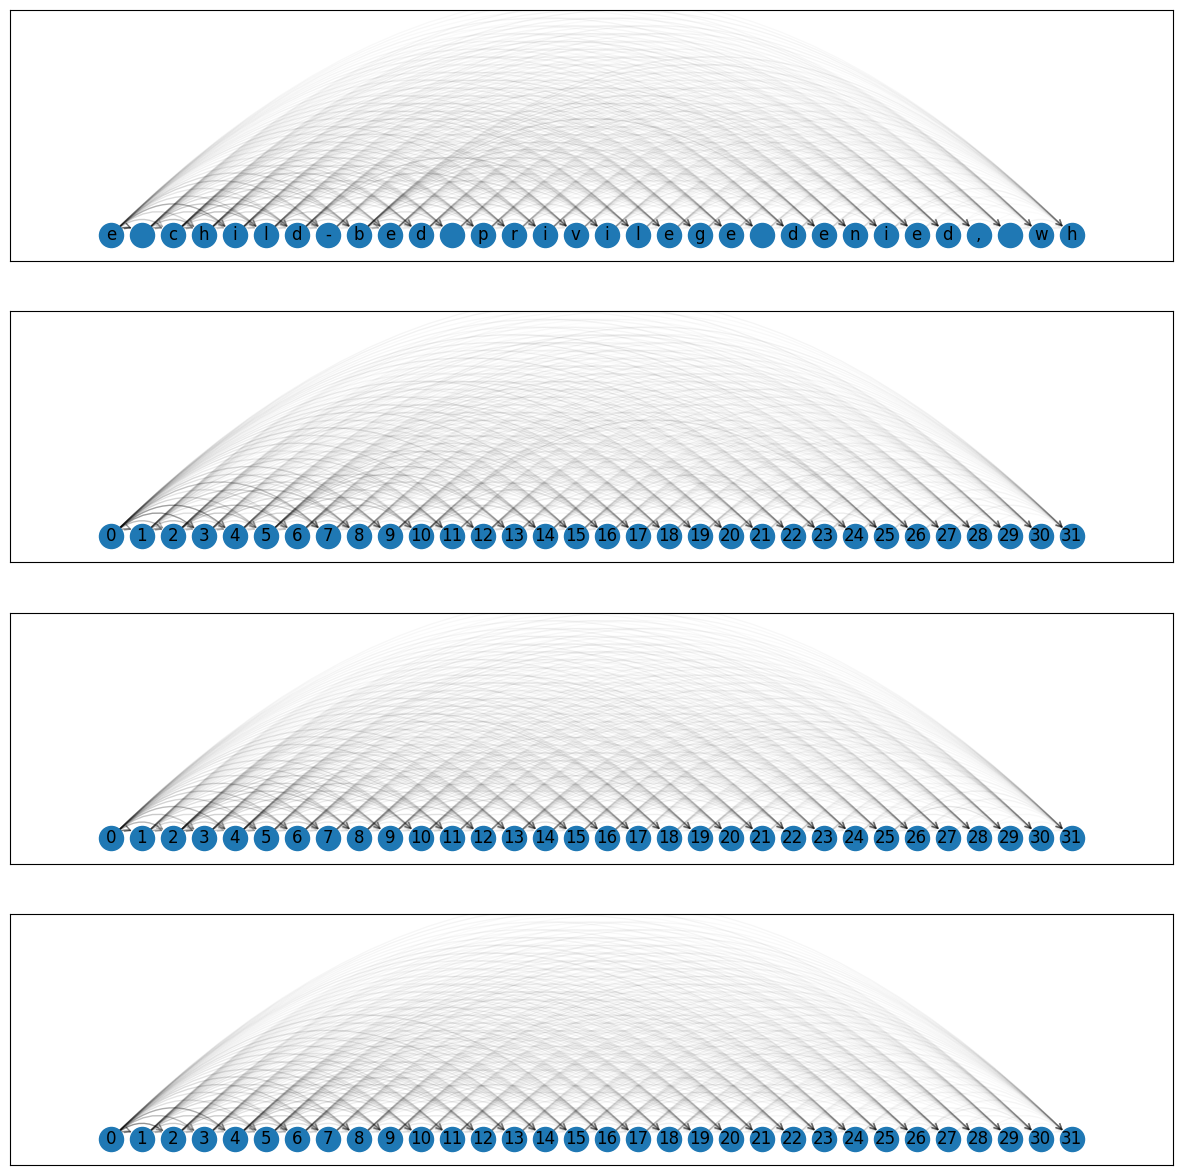

In [314]:
fig, ax = plt.subplots(num_blocks, 1, num=1, figsize=(15, 15))

for i, (x, attn) in enumerate(zip(xs, attns)):
    ix = np.unravel_index(i, ax.shape)
    plt.sca(ax[ix])

    if i == 0:
        labels = {i: label for i, label in enumerate(decode(xb[0].tolist()))}
    else:
        labels = {i: i for i in range(xb.shape[1])}

    visualize_attention_weights(labels, attn[0].tolist()[0])

plt.show()


In [266]:
for attn in attns:
    print(attn[0])


tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5828, 0.4172, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2577, 0.5520, 0.1903,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0835, 0.0626, 0.0681,  ..., 0.0695, 0.0000, 0.0000],
         [0.0926, 0.0449, 0.0446,  ..., 0.0655, 0.0555, 0.0000],
         [0.0746, 0.0598, 0.0446,  ..., 0.0630, 0.0656, 0.0417]],

        [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5481, 0.4519, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2551, 0.4246, 0.3204,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0587, 0.0591, 0.0320,  ..., 0.0623, 0.0000, 0.0000],
         [0.0588, 0.0570, 0.0512,  ..., 0.0378, 0.0912, 0.0000],
         [0.0838, 0.0734, 0.0915,  ..., 0.0901, 0.0665, 0.0445]],

        [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5655, 0.4345, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3573, 0.2814, 0.3613,  ..., 0.0000, 0.0000, 0.

In [273]:
print(attn[0][0])


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4740, 0.5260, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3404, 0.2809, 0.3787, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2049, 0.2468, 0.2766, 0.2717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1854, 0.1763, 0.2836, 0.1944, 0.1603, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1073, 0.1373, 0.2696, 0.1930, 0.1665, 0.1264, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1572, 0.1502, 0.1223, 0.1051, 0.1161, 0.1411, 0.2080, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.00